In [38]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from datetime import timedelta
from sklearn.metrics import root_mean_squared_error
import pickle
from pmdarima.arima import auto_arima
from prepare_data import PrepareData

Get Data

In [39]:
df = PrepareData.df
train_data = PrepareData.train_data()
test_data = PrepareData.test_data()

# Training sarima to predict the temperature 

## EDA

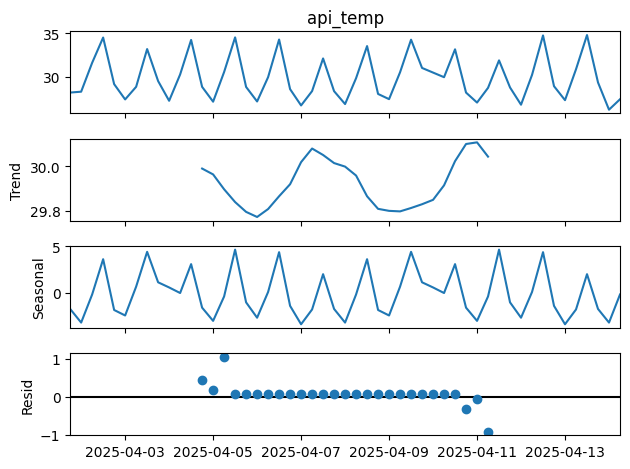

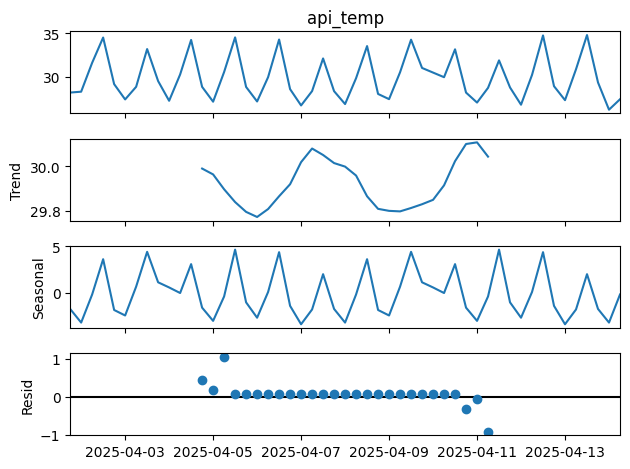

In [40]:
seasonal_decompose(df["api_temp"].interpolate(), model="additive").plot()

### Find the D parameter

In [41]:
result = adfuller(df["api_temp"].dropna(), autolag="AIC")
print("ADF Statistic:", result[0])
print("p-value:", result[1])
for key, value in result[4].items():
    print("Critial Values:")
    print(f"   {key}, {value}")

ADF Statistic: -3.9526802941039483
p-value: 0.0016796001132285308
Critial Values:
   1%, -3.584828853223594
Critial Values:
   5%, -2.9282991495198907
Critial Values:
   10%, -2.6023438271604937


The ADF statistics value is less than 0.05, therefore, it is stationary.

### Find the P parameter

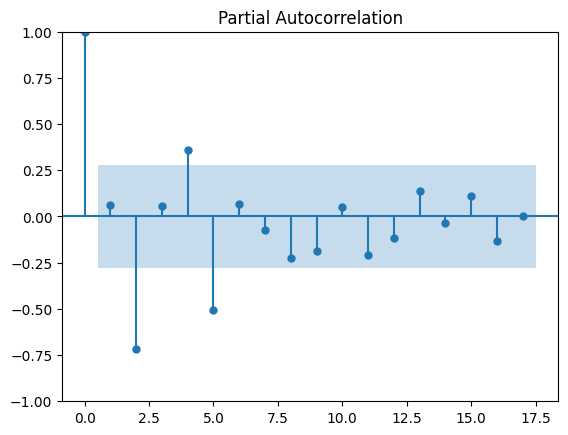

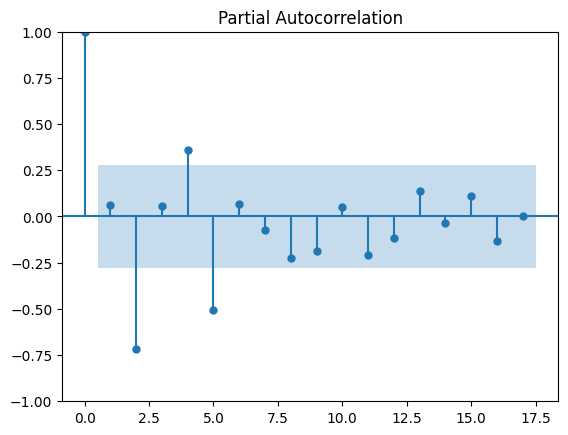

In [42]:
# I believe 2 or 3 is the variable for the term AR in order
plot_pacf(df["api_temp"].dropna())

The three lags in the front are the most influential, therefore, p = 3

### Find the Q parameter

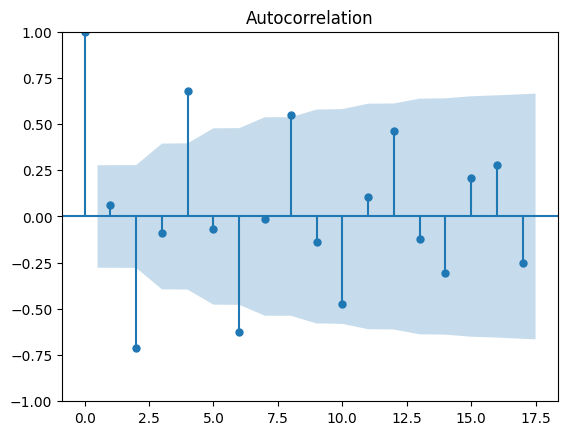

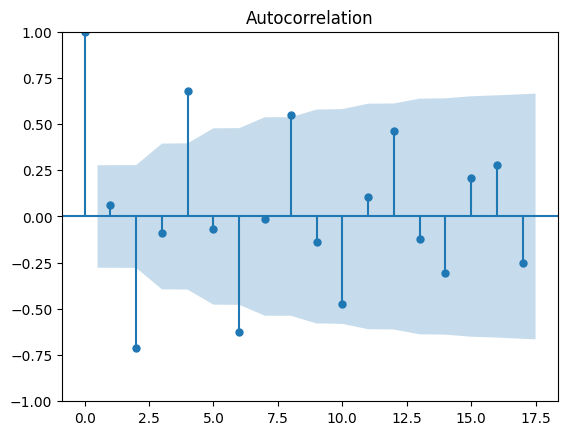

In [43]:
plot_acf(df["api_temp"].dropna())

The graph is not clear, therefore, the q parameter might be 0 or 1

## Pre-Processing

Fill in missing temperature value (due to server outage)
Use ffill, which replace NULL values with the value from the previous row.

In [44]:
train_data["api_temp"] = train_data["api_temp"].ffill()
test_data["api_temp"] = test_data["api_temp"].ffill()

/tmp/ipykernel_85128/1244216577.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data["api_temp"] = train_data["api_temp"].ffill()
/tmp/ipykernel_85128/1244216577.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data["api_temp"] = test_data["api_temp"].ffill()


## Train the model

In [45]:
model_api_temp = SARIMAX(
    endog=train_data["api_temp"], order=(1, 0, 1), seasonal_order=(1, 0, 1, 3)
)
api_temp_results = model_api_temp.fit()

api_temp_prediction = api_temp_results.get_forecast(
    steps=int(test_data["api_temp"].count())
).predicted_mean
forecast_index = pd.date_range(
    start=test_data.index[0],
    freq=timedelta(days=1),
    periods=int(test_data["api_temp"].count()),
)
api_temp_prediction.columns = ["predicted"]

print(api_temp_prediction)

/home/jang/ske/da/project-sarimax/env/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


2025-04-08 06:00:00    29.759754
2025-04-08 12:00:00    29.746574
2025-04-08 18:00:00    29.743729
2025-04-09 00:00:00    29.759233
2025-04-09 06:00:00    29.746058
2025-04-09 12:00:00    29.743213
2025-04-09 18:00:00    29.758711
2025-04-10 00:00:00    29.745540
2025-04-10 06:00:00    29.742696
Freq: 6h, Name: predicted_mean, dtype: float64


/home/jang/ske/da/project-sarimax/env/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


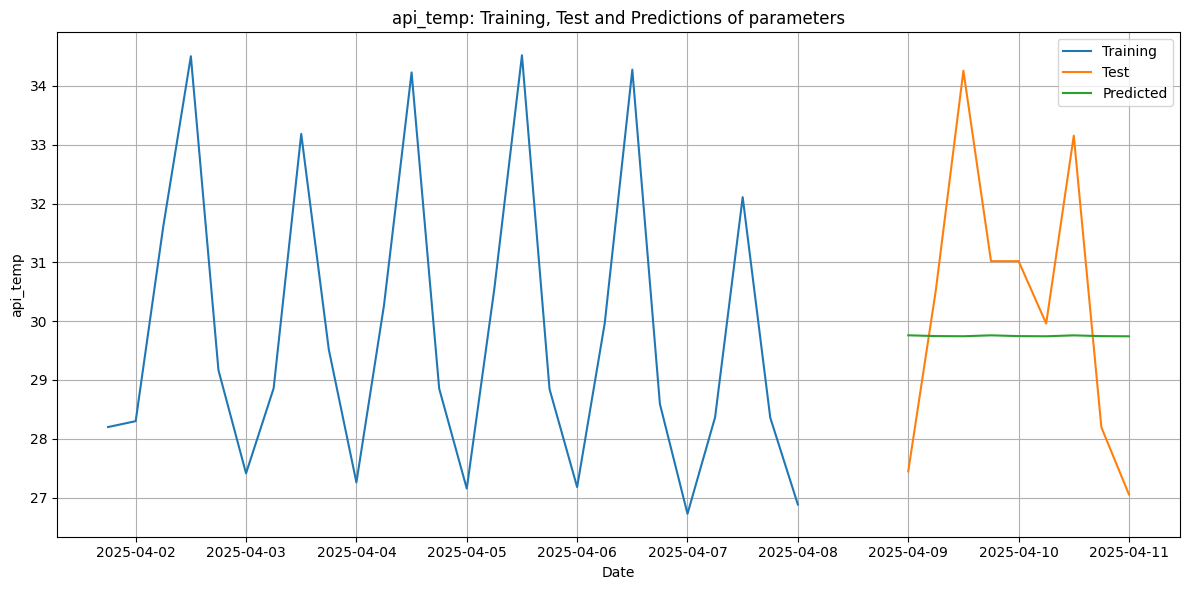

RMSE is :  2.374872777760055


In [46]:
plt.figure(figsize=(12, 6))
# Ensure datetime index and proper plotting
plt.plot(train_data.index, train_data["api_temp"], label="Training")
plt.plot(test_data.index, test_data["api_temp"], label="Test")
plt.plot(
    test_data.index, api_temp_prediction, label="Predicted"
)  # use the same x-axis as test

plt.legend()
plt.xlabel("Date")
plt.ylabel("api_temp")
plt.title("api_temp: Training, Test and Predictions of parameters")
plt.grid(True)
plt.tight_layout()
plt.show()

print("RMSE is : ", root_mean_squared_error(test_data["api_temp"], api_temp_prediction))

## Save the model using pickle

In [47]:
with open("../exports/api_temp_sarima.pkl", "wb") as file:
    pickle.dump(api_temp_results, file)